# Hands on : DNN Training HEP dataset

This tutorial will be focused on the classification problem in a physics example: training a neural network classifier to distinguish the Higgs boson signals from background events.

In this tutorial, we will use TensorFlow and Keras to train our neural networks (different from the first hands on tutorial which uses PyTorch), but the concept is the same, and we will be focused more on data processing, model optimization and overtraining.

Outline:
- Load data from root files
- Explore the data and weights
- Preprocess data for training
- Train a neural network
- Quantify its performance
- Model tuning and overtraining

## Import software

In [1]:
import numpy as np  # numpy is a python package for data processing
import pandas as pd  # pandas is a python package for data processing
import matplotlib.pyplot as plt  # matplotlib is a powerful package for plotting results
import uproot  # uproot is a useful python package to read data from root files
import tensorflow as tf
from keras.metrics import AUC

print("Tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

pd.set_option("display.max_columns", None)  # to see all columns of df.head()

Tensorflow version: 2.17.0
Num GPUs Available:  0


## Load events

Data were created from ATLAS Open Data:

http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html

The dataset we will be using contains MC simulation of the Standard Model Higgs boson production events (signal), as well as Standard Model background, including top-quark-pair production, single-top production, production of weak bosons in association with jets (W+jets, Z+jets) and production of a pair of bosons (diboson WW, WZ, ZZ).

All the data are stored in a root file, which contains different kinematic variables of each event, the event label (`label`) to indicate whether an event is a signal or background, as well as the MC event weights (`mcWeight`). We use [uproot](https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf) to read data from the root file.

In [19]:
filename = "dataWW_d1.root"
file = uproot.open(filename)

# show what is inside the root file loaded from uproot
print(file.classnames())

# select the TTree inside the root file
tree = file["tree_event"]

# show all the branches inside the TTree
tree.show()

# convert uproot TTree into pandas dataframe
dfall = tree.arrays(library="pd")

print("File loaded with ", len(dfall), " events ")

{'tree_event;1': 'TTree'}
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
index                | int64_t                  | AsDtype('>i8')
eventNumber          | int64_t                  | AsDtype('>i8')
label                | int64_t                  | AsDtype('>i8')
met_et               | double                   | AsDtype('>f8')
met_phi              | double                   | AsDtype('>f8')
lep_n                | int64_t                  | AsDtype('>i8')
lep_pt_0             | double                   | AsDtype('>f8')
lep_pt_1             | double                   | AsDtype('>f8')
lep_eta_0            | double                   | AsDtype('>f8')
lep_eta_1            | double                   | AsDtype('>f8')
lep_phi_0            | double                   | AsDtype('>f8')
lep_phi_1            | double                   | AsDtype('>f8')
lep_E_0              | double   

In [20]:
# dump list of feature
dfall.columns

Index(['index', 'eventNumber', 'label', 'met_et', 'met_phi', 'lep_n',
       'lep_pt_0', 'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0',
       'lep_phi_1', 'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1',
       'lep_type_0', 'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1',
       'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1', 'jet_E_0',
       'jet_E_1', 'mcWeight', 'runNumber', 'channelNumber'],
      dtype='object')

In [21]:
# examine first few events
dfall.head()

,index,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,0,249632,1,25.118,1.14010,2,46.439,44.589,0.131030,0.40654,2.34760,-2.41510,46838.0,48325.0,1,-1,13,11,1,53.680,-7.000,2.4346,-7.00000,-0.76667,-7.00000,308720.0,-7.0,0.000002,284500,345323
1,1,892975,1,27.974,0.84442,2,86.819,55.438,-0.017265,-0.16338,-1.44520,-1.72950,86832.0,56179.0,1,-1,11,13,1,126.700,-7.000,-1.2789,-7.00000,1.66290,-7.00000,245670.0,-7.0,0.000002,284500,345323
2,2,730573,0,123.290,-2.94810,2,105.810,40.506,-1.338900,-1.03500,0.68539,-0.90527,215700.0,64211.0,1,-1,13,13,0,-7.000,-7.000,-7.0000,-7.00000,-7.00000,-7.00000,-7.0,-7.0,0.002468,284500,363492
3,3,717584,0,78.558,1.04450,2,56.666,35.124,2.294600,1.88700,2.13110,-2.83820,283930.0,118570.0,-1,1,11,11,2,79.799,53.942,1.6270,0.55314,-1.84880,-0.47055,211610.0,63629.0,0.000197,284500,363492
4,4,319020,0,15.863,0.74840,2,94.708,72.811,0.812740,0.77954,1.84940,0.45967,127750.0,96077.0,-1,1,11,11,1,143.180,-7.000,-0.6358,-7.00000,-1.91230,-7.00000,173810.0,-7.0,0.000197,284500,363492


## Event Selection

In this example, we want to focus on events with exactly 2 leptons. In addition, we only keep events with positive event weight (the column `mcWeight`) to make it simple. This might change the differential distribution, but the DNN training will not work with negative weights (as this turns the minimization procedure into a maximization procedure).

In [22]:
print("Number of events before selections:", len(dfall))
# only keep events with exactly two leptons
mask = dfall.lep_n == 2
# only keep events with positive event weights
mask = mask & (dfall.mcWeight > 0)
# apply mask
fulldata = dfall[mask]
print("Number of events after selections:", len(fulldata))

Number of events before selections: 600000
Number of events after selections: 577357


The column `label` is whether an event is a signal (Higgs boson events) or a background. An event with the `label == 1` means it is a signal event, otherwise (`label == 0`) it is a background event.

The event weights (`mcWeight`) will be used during the training. The event with a larger weight will have a larger contribution in the loss function.

In [23]:
target = fulldata.label
weights = fulldata.mcWeight

print("Number of selected signal events:", len(fulldata[target == 1]))
print("Number of selected background events:", len(fulldata[target == 0]))

Number of selected signal events: 396976
Number of selected background events: 180381


### For simplicity, we'll only use some features on the first pass

In [24]:
# Use a certain set of features
used_features = ["met_et", "met_phi", "lep_pt_0", "lep_pt_1", "lep_phi_0", "lep_phi_1"]
# Or we can use more features to improve the discrimination power:
# used_features = [
#     "met_et",
#     "met_phi",
#     "lep_pt_0",
#     "lep_pt_1",
#     "lep_eta_0",
#     "lep_eta_1",
#     "lep_phi_0",
#     "lep_phi_1",
#     "jet_n",
#     "jet_pt_0",
#     "jet_pt_1",
#     "jet_eta_0",
#     "jet_eta_1",
#     "jet_phi_0",
#     "jet_phi_1",
# ]
# We can also engineer our own feature:
# data["lep_deltaphi"] = np.abs(
#     np.mod(data.lep_phi_1 - data.lep_phi_0 + 3 * np.pi, 2 * np.pi) - np.pi
# )

data = pd.DataFrame(fulldata, columns=used_features)
data.head()

,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,25.118,1.14010,46.439,44.589,2.34760,-2.41510
1,27.974,0.84442,86.819,55.438,-1.44520,-1.72950
2,123.290,-2.94810,105.810,40.506,0.68539,-0.90527
3,78.558,1.04450,56.666,35.124,2.13110,-2.83820
4,15.863,0.74840,94.708,72.811,1.84940,0.45967


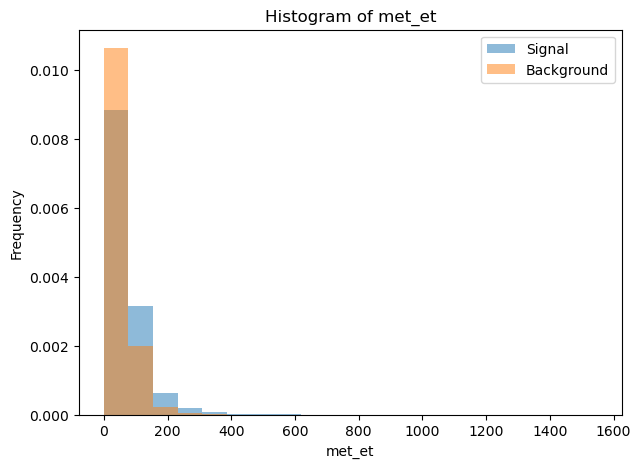

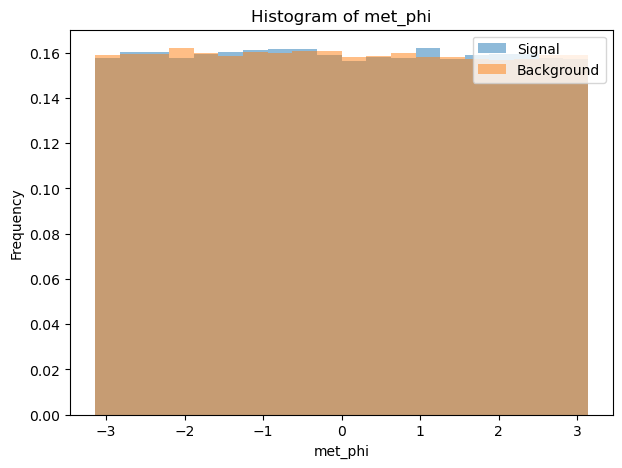

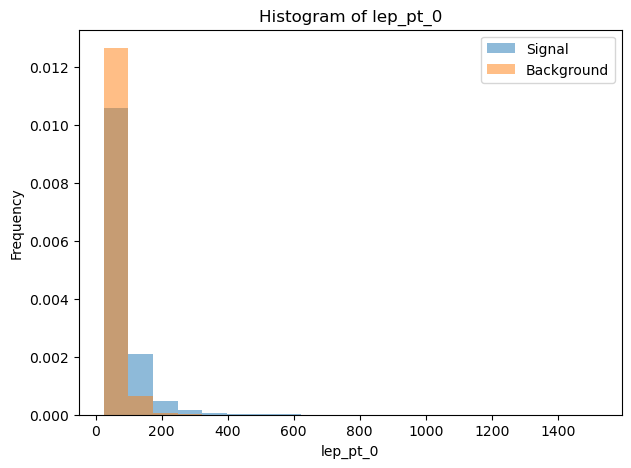

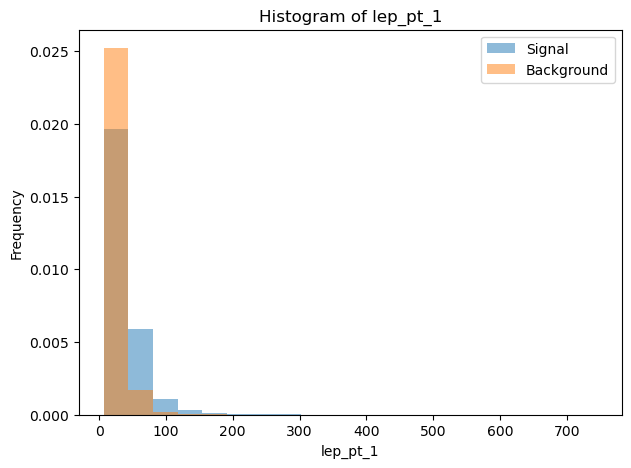

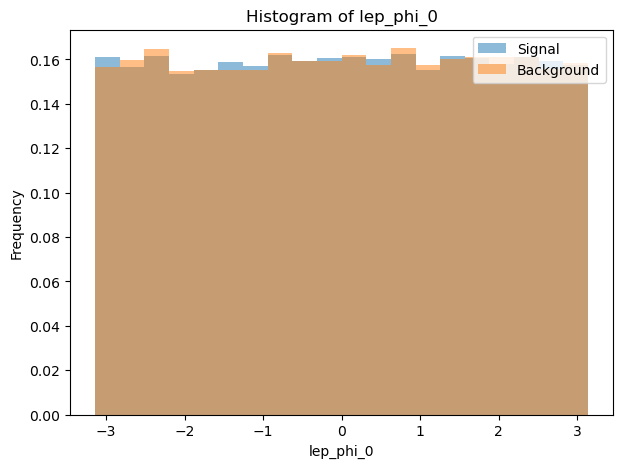

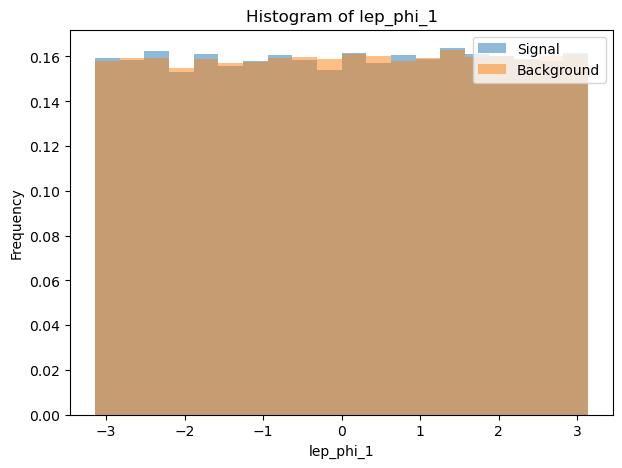

In [25]:
# Separate the data into signal and background
signal = data[target == 0]
background = data[target == 1]

# Plot histograms for each feature
for column in data.columns:
    plt.figure(figsize=(7, 5))

    _, bins, __ = plt.hist(signal[column], bins=20, alpha=0.5, label='Signal', density=True)  # fmt: skip
    plt.hist(background[column], bins=bins, alpha=0.5, label='Background', density=True)  # fmt: skip

    # # Use log scale on y Axis
    # plt.yscale("log")

    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")

    plt.show()

## Data splitting

It is very common in machine learning to split data into multiple independent sets, and only use part of the data for training/optimizing the machine learning models, and the rest for testing/evaluating performance.

In the following, we will split the whole data into 50% training set, 25% validation set and 25% test set:

- __Training Dataset:__ The sample of data used to fit the model.
- __Validation Dataset:__ The sample used to provide an unbiased evaluation of a model fit on the training dataset while tuning  hyperparameters.
- __Test Dataset:__ The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.


The API referecne of the `train_test_split` function:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

### Split the Data into training set, validation set, and test set

In [26]:
from sklearn.model_selection import train_test_split

# turn data into numpy arrays
data = data.values

(
    X_train,
    X_val_and_test,
    y_train,
    y_val_and_test,
    weights_train,
    weights_val_and_test,
) = train_test_split(data, target, weights, train_size=0.5)

(
    X_test,
    X_val,
    y_test,
    y_val,
    weights_test,
    weights_val,
) = train_test_split(
    X_val_and_test, y_val_and_test, weights_val_and_test, train_size=0.5
)

### Split the rest (val + test) into validation set and test set

In [27]:
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("weights_train shape: ", weights_train.shape, "\n")
print("X_val Shape: ", X_val.shape)
print("y_val Shape: ", y_val.shape)
print("weights_val shape: ", weights_val.shape, "\n")
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)
print("weights_test shape: ", weights_test.shape)

X_train Shape:  (288678, 6)
y_train Shape:  (288678,)
weights_train shape:  (288678,) 

X_val Shape:  (144340, 6)
y_val Shape:  (144340,)
weights_val shape:  (144340,) 

X_test Shape:  (144339, 6)
y_test Shape:  (144339,)
weights_test shape:  (144339,)


## Standardize the Data

When optimizing the node weights of a neural network, the input scale can significantly affect the performance. That is, unscaled (raw) input variables can result in a slow or unstable learning process. We would therefore like to rescale input variables prior to training a neural network model.

There are 2 common ways to rescale the data:

1. **Scale to Mean of 0 and Variance of 1.0:**   $\ \ \ \ x^\prime = (x-\mu)/\sigma$
2. **Scale to Max of 1 and Min of 0:**   $\ \ \ \ x^\prime = (x-x_{\mathrm{min}})/(x_{\mathrm{max}}-x_{\mathrm{min}})$

In the following, we will go with the first approach, but feel free to try the second approach! (hint: use [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))

In [28]:
from sklearn.preprocessing import StandardScaler


def print_stats(data, name):
    """Print mean and standard deviation of the dataset with consistent spacing."""
    mean = np.array2string(
        data.mean(axis=0).round(2),
        precision=2,
        floatmode="fixed",
        suppress_small=True,
    )
    std = np.array2string(
        data.std(axis=0).round(2),
        precision=2,
        floatmode="fixed",
        suppress_small=True,
    )
    print(f"{name} mean: {mean}, std: {std}")


# Print statistics before standardization
print("Before standardization:")
print_stats(X_train, "X_train")
print_stats(X_val, "X_val  ")
print_stats(X_test, "X_test ")
print()

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print statistics after standardization
print("After standardization:")
print_stats(X_train, "X_train")
print_stats(X_val, "X_val  ")
print_stats(X_test, "X_test ")

Before standardization:
X_train mean: [60.52 -0.01 60.05 27.86  0.00  0.01], std: [46.85  1.81 40.78 20.18  1.81  1.81]
X_val   mean: [60.57 -0.00 60.12 27.87  0.01  0.01], std: [47.29  1.82 41.14 20.08  1.81  1.81]
X_test  mean: [60.32 -0.01 59.99 27.83  0.01  0.01], std: [46.41  1.81 41.08 19.95  1.81  1.82]

After standardization:
X_train mean: [ 0.00  0.00 -0.00  0.00 -0.00 -0.00], std: [1.00 1.00 1.00 1.00 1.00 1.00]
X_val   mean: [ 0.00  0.00  0.00  0.00  0.00 -0.00], std: [1.01 1.00 1.01 0.99 1.00 1.00]
X_test  mean: [-0.00 -0.00 -0.00 -0.00  0.00 -0.00], std: [0.99 1.00 1.01 0.99 1.00 1.00]


## Adjust the Signal/Background Weights for balanced training
Naturally, we would like to have an equal emphasis on the signal and background during the training. To do so, we can "normalize" the signal weights, and background weights such that the sum of weights is the same between signal and background. Note that the adjustment is only needed for train and validation sets, as we do not use test set to calculate the loss function.

In [29]:
def print_weight_sums(weights, labels, dataset_name):
    """Print the sum of signal and background weights with consistent spacing."""
    signal_sum = weights[labels == 1].sum()
    background_sum = weights[labels == 0].sum()
    print(f"Sum of {dataset_name} signal weights: {signal_sum:.2f}")
    print(f"Sum of {dataset_name} background weights: {background_sum:.2f}")


# Print weight sums before normalization
print("Before normalization:")
print_weight_sums(weights_train, y_train, "training")
print_weight_sums(weights_val, y_val, "validation")
print()

# Normalize the weights
weights_train[y_train == 0] *= len(weights_train) / weights_train[y_train == 0].sum()
weights_train[y_train == 1] *= len(weights_train) / weights_train[y_train == 1].sum()

weights_val[y_val == 0] *= len(weights_val) / weights_val[y_val == 0].sum()
weights_val[y_val == 1] *= len(weights_val) / weights_val[y_val == 1].sum()

# Print weight sums after normalization
print("After normalization:")
print_weight_sums(weights_train, y_train, "training")
print_weight_sums(weights_val, y_val, "validation")

Before normalization:
Sum of training signal weights: 3.09
Sum of training background weights: 80.04
Sum of validation signal weights: 1.55
Sum of validation background weights: 39.74

After normalization:
Sum of training signal weights: 288678.00
Sum of training background weights: 288678.00
Sum of validation signal weights: 144340.00
Sum of validation background weights: 144340.00


## Training the neural network

In the following, we will use TensorFlow and Keras to build our neural network and train the model.

The architecture is pretty simple: A fully-connected network with 2 hidden layers with the ReLu activation function.
The last layer uses the Sigmoid activation to output a classifier score that ranges from 0 to 1.

In [30]:
model = tf.keras.models.Sequential(
    [
        tf.keras.Input((X_train.shape[1],)),  # Input layer
        tf.keras.layers.Dense(128, activation="relu"),  # 1st hidden layer
        tf.keras.layers.Dense(128, activation="relu"),  # 2nd hidden layer
        tf.keras.layers.Dense(1, activation="sigmoid"),  # Output layer
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,537 (68.50 KB)

 Trainable params: 17,537 (68.50 KB)

 Non-trainable params: 0 (0.00 B)

We will use the binary cross-entropy as the loss function, and use the Adam optimizer to train the model.

In [31]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    weighted_metrics=[AUC(name="auc")],
)
# Try other options:
# SGD optimizer: optimizer=tf.keras.optimizers.experimental.SGD
# MSE loss: loss="mean_squared_error"

In the following, we train the model with 10 epochs with a batch size of 128.

In [32]:
print("Start training!")
the_fit = model.fit(
    X_train,
    y_train.values,
    sample_weight=weights_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val, weights_val),
    # callbacks=[K.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')], # uncomment to use early stopping (should also increase the epochs)
)

Start training!
Epoch 1/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 2s 759us/step - auc: 0.8305 - loss: 0.9815 - val_auc: 0.8651 - val_loss: 0.8717
Epoch 2/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 2s 706us/step - auc: 0.8648 - loss: 0.8706 - val_auc: 0.8682 - val_loss: 0.8607
Epoch 3/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 2s 701us/step - auc: 0.8676 - loss: 0.8616 - val_auc: 0.8662 - val_loss: 0.8639
Epoch 4/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 2s 703us/step - auc: 0.8682 - loss: 0.8585 - val_auc: 0.8674 - val_loss: 0.8601
Epoch 5/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 2s 713us/step - auc: 0.8705 - loss: 0.8547 - val_auc: 0.8695 - val_loss: 0.8579
Epoch 6/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 2s 706us/step - auc: 0.8696 - loss: 0.8534 - val_auc: 0.8691 - val_loss: 0.8570
Epoch 7/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step - auc: 0.8693 - loss: 0.8512 - val_auc: 0.8716 - val_loss: 0.8466
Epoch 8/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 2s 698us/step - auc: 0.8712 - loss: 0.8511 - val_auc: 0.8684 - val_loss: 0.8622
Epoch 9/

### Plot the training progress

Below, we plot the training loss, validation loss, training AUC and validation AUC per epoch.

Ideally, we should see the loss going down, and AUC going up with the number of epochs trained.

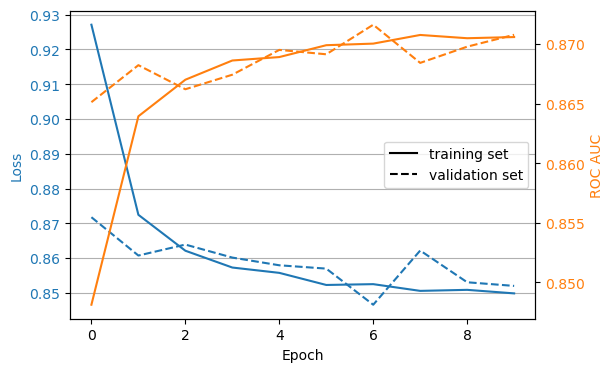

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(the_fit.history["loss"], color="tab:blue")
ax.plot(the_fit.history["val_loss"], color="tab:blue", ls="--")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss", color="tab:blue")
ax.tick_params(axis="y", labelcolor="tab:blue")
ax.grid(True, axis="y")

ax2 = ax.twinx()
ax2.set_ylabel("ROC AUC", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.plot(the_fit.history["auc"], color="tab:orange")
ax2.plot(the_fit.history["val_auc"], color="tab:orange", ls="--")

ax2.plot([], [], color="black", label="training set")
ax2.plot([], [], color="black", ls="--", label="validation set")
ax2.legend(loc="right")

### Use the model to make predicions!
Evaluate the model based on predictions made with X_test $\rightarrow$ y_test

In [34]:
y_pred_test = model.predict(X_test).flatten()
y_pred_train = model.predict(X_train).flatten()

print("y_pred_test: ", y_pred_test)
print("y_pred_train: ", y_pred_train)

4511/4511 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step
9022/9022 ━━━━━━━━━━━━━━━━━━━━ 2s 243us/step
y_pred_test:  [0.67677855 0.30305755 0.7346815  ... 0.8339344  0.76285547 0.7773114 ]
y_pred_train:  [0.78309214 0.81739193 0.69188565 ... 0.52039135 0.31173408 0.7078744 ]


### ROC curves and Area Under the Curve (AUC)

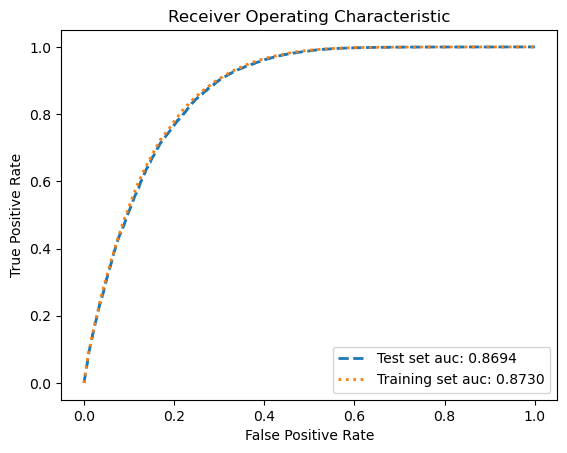

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(
    y_true=y_test,
    y_score=y_pred_test,
    sample_weight=weights_test,
)
fpr_train, tpr_train, _ = roc_curve(
    y_true=y_train,
    y_score=y_pred_train,
    sample_weight=weights_train,
)
auc_test = roc_auc_score(
    y_true=y_test,
    y_score=y_pred_test,
    sample_weight=weights_test,
)
auc_train = roc_auc_score(
    y_true=y_train.values,
    y_score=y_pred_train,
    sample_weight=weights_train,
)
plt.plot(
    fpr_test,
    tpr_test,
    color="tab:blue",
    lw=2,
    ls="--",
    label=f"Test set auc: {auc_test:.4f}",
)
plt.plot(
    fpr_train,
    tpr_train,
    color="tab:orange",
    lw=2,
    ls=":",
    label=f"Training set auc: {auc_train:.4f}",
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

### Plotting NN Score for Signal and Background

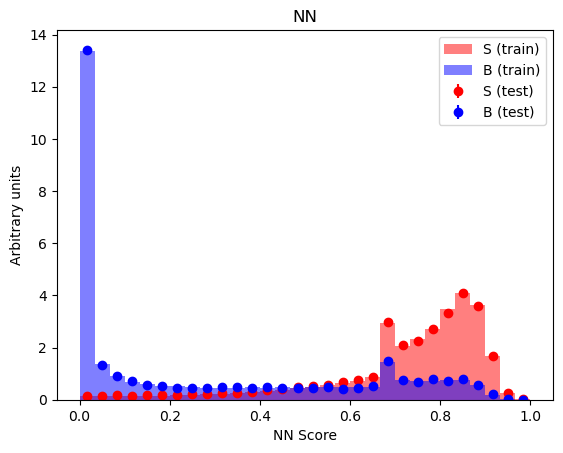

In [36]:
from extra_functions import compare_train_test

compare_train_test(
    y_pred_train,
    y_train,
    y_pred_test,
    y_test,
    xlabel="NN Score",
    title="NN",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
)

## Significance Function

In a standard statistical analysis for a search, an observed significance is obtained. This corresponds to the significance with which we reject the background-only hypothesis. That is, the higher the significance, the more likely the signal we are searching for exists.

We can use the formula below to obtain an estimated value of the expected significance.

$Z = \sqrt{2+((s+b)\ln(1+s/b)-s)}$

**see [arXiv:1007.1727](https://arxiv.org/pdf/1007.1727.pdf) [Eq. 97]**

This corresponds to the signal sensitivity. This is a good indication of the performance of our classification model. => We want the significance to be as high as possible.



In [37]:
from math import sqrt
from math import log


def amsasimov(s, b):
    if b <= 0 or s <= 0:
        return 0
    try:
        return sqrt(2 * ((s + b) * log(1 + float(s) / b) - s))
    except ValueError:
        print(1 + float(s) / b)
        print(2 * ((s + b) * log(1 + float(s) / b) - s))

The simplest way to use the classifier score to separate signal and background is to make a cut on the classifier score for all the events. In the following, we scan through the cut value and look at the corresponding significance. This can help us determine the optimal cut value of the classifier score.

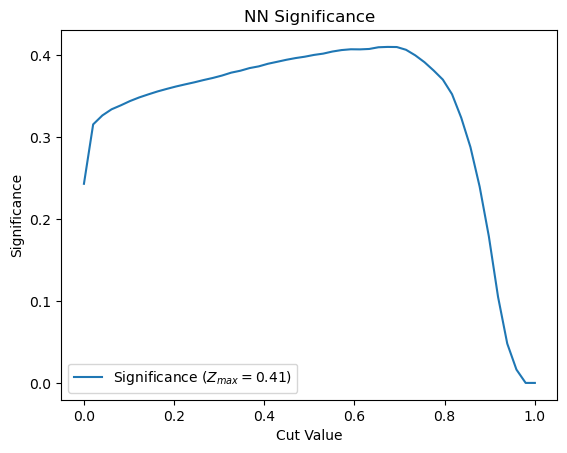

In [38]:
int_pred_test_sig = [
    weights_test[(y_test == 1) & (y_pred_test > th_cut)].sum()
    for th_cut in np.linspace(0, 1, num=50)
]
int_pred_test_bkg = [
    weights_test[(y_test == 0) & (y_pred_test > th_cut)].sum()
    for th_cut in np.linspace(0, 1, num=50)
]
vamsasimov = [
    amsasimov(sumsig, sumbkg)
    for (sumsig, sumbkg) in zip(int_pred_test_sig, int_pred_test_bkg)
]
Z = max(vamsasimov)

plt.plot(
    np.linspace(0, 1, num=50),
    vamsasimov,
    label=f"Significance ($Z_{{max}} = {np.round(Z, decimals=2)}$)",
)
plt.title("NN Significance")
plt.xlabel("Cut Value")
plt.ylabel("Significance")
plt.legend()
plt.show()

## What does overtraining look like?

Recipe:
1. Add More layers
2. Add more nodes per layer
3. Train on less data
4. Train for more iterations

In [39]:
# Crazy Example
N = len(X_train)
n = int(N / 10000)
print("Using", n, "/", N, "events")

X_small = X_train[:n]
y_small = y_train[:n]
weights_small = weights_train[:n]

Using 28 / 288678 events


In [40]:
ot_model = tf.keras.models.Sequential(
    [
        tf.keras.Input((X_small.shape[1],)),  # input layer
        tf.keras.layers.Dense(512, activation="relu"),  # 1st hiddden layer
        tf.keras.layers.Dense(512, activation="relu"),  # 2nd hiddden layer
        tf.keras.layers.Dense(512, activation="relu"),  # ...
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
ot_model.compile(
    loss="binary_crossentropy", optimizer="adam", weighted_metrics=[AUC(name="auc")]
)

the_overfit = ot_model.fit(
    X_small,
    y_small.values,
    sample_weight=weights_small,
    epochs=25,
    batch_size=128,
    validation_data=(X_val, y_val, weights_val),
)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - auc: 0.7690 - loss: 0.8415 - val_auc: 0.5501 - val_loss: 1.3967
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - auc: 0.8478 - loss: 0.7014 - val_auc: 0.5421 - val_loss: 1.4682
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - auc: 0.8403 - loss: 0.6045 - val_auc: 0.5468 - val_loss: 1.5889
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - auc: 0.8386 - loss: 0.5266 - val_auc: 0.5568 - val_loss: 1.7501
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - auc: 0.8550 - loss: 0.4641 - val_auc: 0.5684 - val_loss: 1.9209
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - auc: 0.8739 - loss: 0.4150 - val_auc: 0.5797 - val_loss: 2.0543
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - auc: 0.8745 - loss: 0.3711 - val_auc: 0.5895 - val_loss: 2.1309
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - auc: 0.9201 - loss: 0.3269 - val_auc: 0.5961 - val_loss: 2.1664
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - auc: 0.9483 - loss: 0.2829 - val_auc: 0.5991 - 

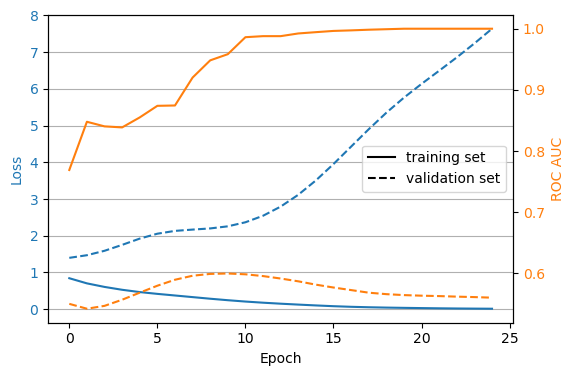

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(the_overfit.history["loss"], color="tab:blue")
ax.plot(the_overfit.history["val_loss"], color="tab:blue", ls="--")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss", color="tab:blue")
ax.tick_params(axis="y", labelcolor="tab:blue")
ax.grid(True, axis="y")

ax2 = ax.twinx()
ax2.set_ylabel("ROC AUC", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.plot(the_overfit.history["auc"], color="tab:orange")
ax2.plot(the_overfit.history["val_auc"], color="tab:orange", ls="--")
# ax2.set_ylim([0, 1])

ax2.plot([], [], color="black", label="training set")
ax2.plot([], [], color="black", ls="--", label="validation set")
ax2.legend(loc="right")

In [42]:
ot_y_pred_test = ot_model.predict(X_test).flatten()
ot_y_pred_train = ot_model.predict(X_small).flatten()

4511/4511 ━━━━━━━━━━━━━━━━━━━━ 3s 550us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


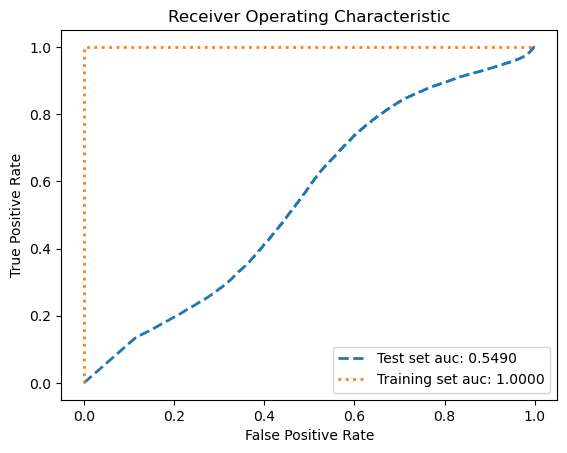

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(
    y_true=y_test, y_score=ot_y_pred_test, sample_weight=weights_test
)
fpr_train, tpr_train, _ = roc_curve(
    y_true=y_small, y_score=ot_y_pred_train, sample_weight=weights_small
)
auc_test = roc_auc_score(
    y_true=y_test, y_score=ot_y_pred_test, sample_weight=weights_test
)
auc_train = roc_auc_score(
    y_true=y_small.values, y_score=ot_y_pred_train, sample_weight=weights_small
)
plt.plot(
    fpr_test,
    tpr_test,
    color="tab:blue",
    lw=2,
    ls="--",
    label=f"Test set auc: {auc_test:.4f}",
)
plt.plot(
    fpr_train,
    tpr_train,
    color="tab:orange",
    lw=2,
    ls=":",
    label=f"Training set auc: {auc_train:.4f}",
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

## Exercises

### Can we try to improve the neural network performance?

Hints:
- Adjust learning rate
- Adjust the number of neurons, and layers
- Increase epochs
- Enable early stopping (and increase max epochs)
- Adjust batch size
- Change activations: [relu, leakyrelu, selu, tanh]
- Try different optimizers (e.g. SGD)
- Dynamic learning rate: e.g. tfa.optimizers.RectifiedAdam as the optimizer, tf.keras.callbacks.ReduceLROnPlateau as a callback
- Use a more complicated structure? e.g. RNN, deep sets, GNN, etc
- More... google!

### What happens when we add more features or engineer aditional Features?

Try it yourself!

### What happens when we don't standardize our inputs?

Try it yourself!

What about a different prescaling (using [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for example?)

### What happens when we don't use balanced weights for signal and background?

Use the raw MC weights and retrain the model.

Does the "natural" weight always give the best performance?